In [8]:
import iflai
import matplotlib.pyplot as plt
from iflai.ml.features_extraction import *
from iflai.ml.feature_selection import AutoFeatureSelection
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from iflai.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns

In [9]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

In [10]:
metadata = pd.DataFrame(columns=["file", "set", "label"])
metadata["file"] = glob.glob("/pstore/data/DS4/Cell_Cycle_Reconstruction/Donor/condition/*.h5")
metadata["set"] = "train"

In [11]:
sample_image = h5py.File(metadata["file"].iloc[0],"r").get("image")[()]
sample_mask = h5py.File(metadata["file"].iloc[0],"r").get("mask")[()]

In [12]:
combined_features = FeatureUnion([("GLCMFeatures", GLCMFeatures()), 
                                  ("MaskBasedFeatures", MaskBasedFeatures()) ,
                                  ("GradientRMS", GradientRMS()) ,
                                  ("BackgroundMean", BackgroundMean()) ,
                                  ("CellShape", CellShape()),
                                  ("HistogramFeatures", HistogramFeatures()),
                                  ("Collocalization", Collocalization())],
                                n_jobs = -1)

combined_features.fit([None,None])
my_list = combined_features.transform([sample_image,sample_mask]) 
df_features = pd.DataFrame(index = metadata.index, columns=list_of_dict_to_dict(my_list).keys() )

In [13]:
for i in tqdm(range(metadata.shape[0])):
    h5_file =  h5py.File(metadata["file"].iloc[i],"r")
    image = h5_file.get("image")[()]
    mask = h5_file.get("mask")[()]
    label = h5_file.get("label")[()]
    h5_file.close()
    features = combined_features.transform([image,mask])
    features = list_of_dict_to_dict(features)
    df_features.loc[i,:] = features
    metadata.loc[i,"label"] = label

100%|██████████| 1350/1350 [00:30<00:00, 43.61it/s]


In [14]:
df_features = df_features.fillna(0.)

In [15]:
index_train , index_test = train_test_split(metadata.index, stratify = metadata["label"])

In [16]:
pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), 
                           ('AutoFeatureSelection', AutoFeatureSelection(top_k = 20)),
                           ('XGBClassifier', XGBClassifier(n_jobs = -1, eval_metric='logloss')) 
                          ],  verbose=True)
pipeline.fit(df_features.loc[index_train,:],  metadata.loc[index_train, "label"])

[Pipeline] ...... (step 1 of 3) Processing MinMaxScaler, total=   0.0s
Calculating mutual info
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic
Calculating xgb
From 174 initial features Selected (correlated): 48
From 174 initial features Selected (uncorrelated): 20
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  32.2s
[Pipeline] ..... (step 3 of 3) Processing XGBClassifier, total=  12.9s


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('AutoFeatureSelection', AutoFeatureSelection()),
                ('XGBClassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='

In [17]:
selected_features = pipeline.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]

              precision    recall  f1-score   support

    Anaphase       0.00      0.00      0.00         4
          G1       0.95      0.97      0.96       159
   Metaphase       0.00      0.00      0.00        17
    Prophase       0.87      0.91      0.89       151
   Telophase       0.78      1.00      0.88         7

    accuracy                           0.88       338
   macro avg       0.52      0.58      0.54       338
weighted avg       0.85      0.88      0.87       338

------------------------------------------------------------
matthews correlation coeff: 0.7960
Cohen Kappa score: 0.7944
Accuracy: 0.8846 & balanced Accuracy: 0.5764
macro F1 score: 0.5443 & micro F1 score: 0.8846
macro Precision score: 0.5180 & micro Precision score: 0.8846
macro Recall score: 0.5764 & micro Recall score: 0.8846
------------------------------------------------------------


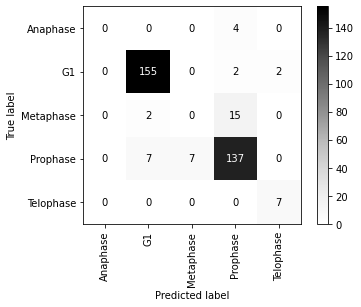

In [18]:
classification_complete_report(pipeline, 
                               df_features.loc[index_test,:], 
                               metadata.loc[index_test, "label"])

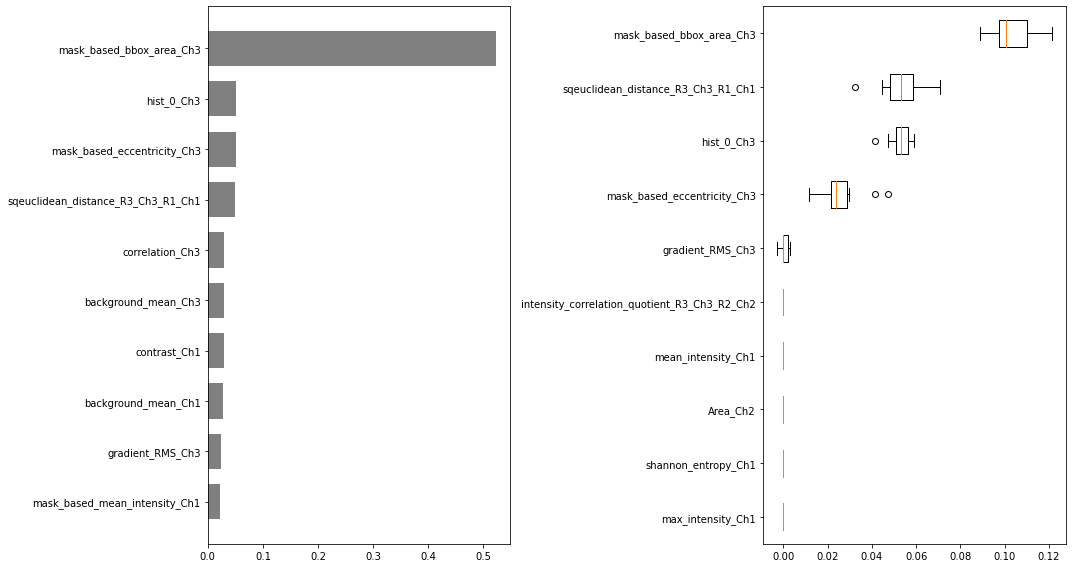

In [19]:

from sklearn.inspection import permutation_importance




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(pipeline.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         pipeline.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(pipeline, 
                                df_features.loc[index_test,:],  
                                metadata.loc[index_test, "label"], n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()

In [20]:

channel_importance_xgb = {"Ch1" : 0., "Ch2" : 0., "Ch3": 0.}

for i,f in enumerate(selected_feature_names):
    value = pipeline.steps[2][1].feature_importances_[i]
    if "Ch1" in f:
        channel_importance_xgb["Ch1"] = channel_importance_xgb["Ch1"] + value
    elif "Ch2" in f:
        channel_importance_xgb["Ch2"] = channel_importance_xgb["Ch2"] + value
    elif "Ch3" in f:
        channel_importance_xgb["Ch3"] = channel_importance_xgb["Ch3"] + value


channel_importance_permutation = {"Ch1" : 0., "Ch2" : 0., "Ch3": 0.}

for i,f in enumerate(df_features.columns):
    value = result['importances_mean'][i]
    if "Ch1" in f:
        channel_importance_permutation["Ch1"] = channel_importance_permutation["Ch1"] + value
    elif "Ch2" in f:
        channel_importance_permutation["Ch2"] = channel_importance_permutation["Ch2"] + value
    elif "Ch3" in f:
        channel_importance_permutation["Ch3"] = channel_importance_permutation["Ch3"] + value


Text(0.5, 1.0, 'Channel importance')

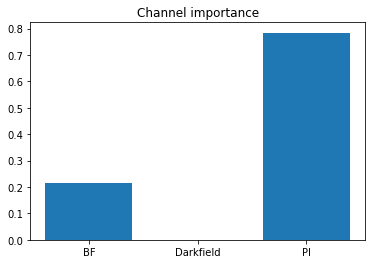

In [21]:
plt.bar(["BF", "Darkfield", "PI"], channel_importance_xgb.values())
plt.title("Channel importance")

Text(0.5, 1.0, 'Channel importance')

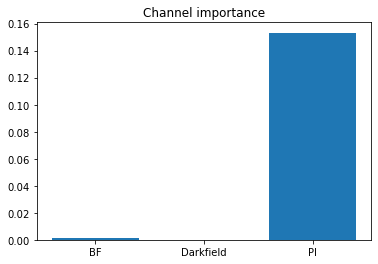

In [22]:
plt.bar(["BF", "Darkfield", "PI"], channel_importance_permutation.values())
plt.title("Permutation importance")